## ATAC + MULTIOME MALES (september 2021)

### Convert to Seurat objects for CICERO

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.21.2
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_res

In [5]:
print(anndata2ri.__version__)
print(anndata.__version__)

1.0.6
0.7.5


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(Signac)
library(Seurat)
library(SeuratDisk)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

For future reference most packages were installed here: */tmp/RtmpGjkK1o/downloaded_packages/*

**Set directories**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_sept2021/"
experiment_prefix = 'males_'

#### Convert the h5ad created with cisTopic into a Seurat object with peaks assay

In [9]:
ATAC_scanpy = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")
ATAC_scanpy

AnnData object with n_obs × n_vars = 52285 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'Immune', 'Erythroid', 'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli', 'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting', 'Neural', 'max', 'leiden', 'cell_type', 'matching_barcode', 'somatic_annotation'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'individual_colors', 

In [10]:
ATAC_scanpy.X

<52285x184906 sparse matrix of type '<class 'numpy.float32'>'
	with 228027573 stored elements in Compressed Sparse Row format>

In [11]:
binary_raw = ATAC_scanpy.layers['binary_raw']
binary_raw

<52285x184906 sparse matrix of type '<class 'numpy.float32'>'
	with 228027573 stored elements in Compressed Sparse Row format>

In [12]:
binary_raw.shape

(52285, 184906)

Step 1: from sparse matrix (python format) to dgcMatrix (R format)

I found this function here: <https://github.com/theislab/anndata2ri/issues/8>

In [13]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [14]:
ATAC_R = csr_to_dgc(binary_raw)
ATAC_R

<rpy2.robjects.methods.RS4 object at 0x7f4321bd9900> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [15]:
%%R -i ATAC_R -o ATAC_dgT

ATAC_dgT <- as(ATAC_R, "dgTMatrix")
print(dim(ATAC_dgT)) # Check the shape of the matrix 

[1] 184906  52285


Step 2: save metadata per cell and per peak and add colnames and rownames to the peak matrix

In [16]:
metadata_cell = ATAC_scanpy.obs
metadata_peak = ATAC_scanpy.var
layers = ATAC_scanpy.layers
reduction_cistopic = ATAC_scanpy.obsm['X_cistopic_38']
reduction_umap = ATAC_scanpy.obsm['X_umap']
reduction_harmony = ATAC_scanpy.obsm['X_harmony']

In [17]:
del ATAC_scanpy.obs['cellatac_clusters']

In [18]:
%%R -i ATAC_dgT -i metadata_cell -i metadata_peak 

rownames(ATAC_dgT) <- rownames(metadata_peak) # Add rownames to peak matrix
colnames(ATAC_dgT) <- rownames(metadata_cell) # Add colnames to peak matrix 

In [19]:
%%R 
print(head(rownames(ATAC_dgT)))
print(head(colnames(ATAC_dgT)))
print(names(ATAC_dgT))

[1] "chr1:816748-817444" "chr1:826607-827807" "chr1:842637-843180"
[4] "chr1:858058-859045" "chr1:868834-869154" "chr1:869371-870234"
[1] "03-AAACGAAAGCTGAGGT-1" "03-AAACGAACAATCATCG-1" "03-AAACGAACATGCACTA-1"
[4] "03-AAACTCGTCACCCGGA-1" "03-AAACTGCCAAGGGTAC-1" "03-AAACTGCGTGAATGTA-1"
NULL


Step 3: build ChromatinAssay with peaks x cells matrix 

In [20]:
%%R -o chrom_assay 

 chrom_assay <- CreateChromatinAssay(
    counts = ATAC_dgT,
    sep = c(":", "-"),
    genome = "hg38",
    ranges = NULL,
 )
chrom_assay

ChromatinAssay data with 184906 features for 52285 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 


Step 4: build Seurat object from chromatin assay 

In [21]:
%%R -o ATAC_Seurat -i metadata_cell

ATAC_Seurat <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = metadata_cell,
  )
ATAC_Seurat

An object of class Seurat 
184906 features across 52285 samples within 1 assay 
Active assay: peaks (184906 features, 0 variable features)


In [22]:
%%R 
print(table(ATAC_Seurat@meta.data$individual))
print(table(ATAC_Seurat@meta.data$cell_type))


 Hrv3 Hrv10 Hrv15 Hrv17 Hrv18 Hrv21 Hrv40 Hrv41 Hrv54 Hrv55 
 6558  2847  3511  7486  4553  5375  5289  5784  5214  5668 

        GermCells           CoelEpi        Supporting           Sertoli 
             1403               470              1686             17020 
 Mesenchymal_LHX9       FetalLeydig Mesenchymal_GATA2                PV 
            10214              2506             11195               511 
           Immune       Endothelial        Epithelial         Erythroid 
             1226              1388              1124               638 
           Neural 
             2904 


Step 5: Add dimensionality reductions to Seurat object 

In [23]:
%%R -i reduction_cistopic -i metadata_cell -o reduction_cistopic_2 

reduction_cistopic_2 <- data.matrix(reduction_cistopic)
key <- "cisTopic_"
colnames(reduction_cistopic_2) <- paste0(key, 1:ncol(x = reduction_cistopic_2))
rownames(reduction_cistopic_2) <- rownames(metadata_cell)
#print(head(reduction_cistopic_2))

In [24]:
%%R -i reduction_umap -i metadata_cell -o reduction_umap_2 

reduction_umap_2 <- data.matrix(reduction_umap)
key2 <- "UMAP_"
colnames(reduction_umap_2) <- paste0(key2, 1:ncol(x = reduction_umap_2))
rownames(reduction_umap_2) <- rownames(metadata_cell)
#print(head(reduction_umap_2))

In [25]:
%%R -i reduction_harmony -i metadata_cell -o reduction_harmony_2 

reduction_harmony_2 <- data.matrix(reduction_harmony)
key3 <- "Harmony_"
colnames(reduction_harmony_2) <- paste0(key3, 1:ncol(x = reduction_harmony_2))
rownames(reduction_harmony_2) <- rownames(metadata_cell)
#print(head(reduction_harmony_2))

In [26]:
%%R 

ATAC_Seurat@reductions$cisTopics <- CreateDimReducObject(embeddings = reduction_cistopic_2, assay = "peaks")
ATAC_Seurat@reductions$umap <- CreateDimReducObject(embeddings = reduction_umap_2, assay = "peaks")
ATAC_Seurat@reductions$harmony <- CreateDimReducObject(embeddings = reduction_harmony_2, assay = "peaks")
ATAC_Seurat

An object of class Seurat 
184906 features across 52285 samples within 1 assay 
Active assay: peaks (184906 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


### Save RDS object of females 

In [27]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat, file = paste0(outdir, experiment_prefix, "_full.rds"))

In [9]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat <- readRDS(file = paste0(outdir, experiment_prefix, "_full.rds"))

## TF motifs with ChromVar

#### Add motifs

In [10]:
%%R -o pfm

# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv10')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}


# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
#print(names(pfmHOMER))
names(pfmHOMER)[93] = "FOXL2.HOMER"
 
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)
#print(names(pfmHOMER))

for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}


# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
}

# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

[1] 638 147 683


#### Add motifs

In [11]:
%%R -o ATAC_Seurat_withMotifs

ATAC_Seurat_withMotifs <- AddMotifs(object = ATAC_Seurat, 
                         genome= BSgenome.Hsapiens.UCSC.hg38, 
                         pfm = pfm, 
                         assay = "peaks", 
                         verbose = TRUE)

ATAC_Seurat_withMotifs

An object of class Seurat 
184906 features across 52285 samples within 1 assay 
Active assay: peaks (184906 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


#### Compute per-cell motif activity scores with chromVar

In [12]:
%%R -o ATAC_Seurat_withChromVar

library(BiocParallel)
register(SerialParam())
ATAC_Seurat_withChromVar <- RunChromVAR(
  object = ATAC_Seurat_withMotifs,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  assay="peaks"
)
ATAC_Seurat_withChromVar

An object of class Seurat 
186826 features across 52285 samples within 2 assays 
Active assay: peaks (184906 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [13]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat_withChromVar, file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))

In [14]:
%%R -i pfm -o motif2names

library(dplyr) 
motif2names <- lapply(pfm, function(x) x@name)
names(motif2names) <- sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [15]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [16]:
%%R 

Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$somatic_annotation
print(table(Idents(ATAC_Seurat_withChromVar)))


    CoelEpi_GATA2      CoelEpi_LHX9       Endothelial        Epithelial 
             1672               661              1388              1124 
        Erythroid       FetalLeydig         GermCells                Gi 
              638              2358              1403               598 
           Immune Mesenchymal_GATA2            Neural                PV 
             1226             11195              2904               511 
          Sertoli                Ti  early_supporting             sPAX8 
            16629              8503               719               756 


In [ ]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(ATAC_Seurat_withChromVar, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'TFs/DARs/all_DA_peaks_LR.csv'))

#### z-scores per cell type annotation

In [10]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar <- readRDS(file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))
DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 
ATAC_Seurat_withChromVar

An object of class Seurat 
186826 features across 52285 samples within 2 assays 
Active assay: chromvar (1920 features, 0 variable features)
 1 other assay present: peaks
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [11]:
%%R -o chromvar_assay

chromvar_assay <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_Seurat_withChromVar))))

In [12]:
chromvar_assay.shape

(52285, 1920)

In [13]:
# Mapping of cells to cell types 
ATAC_scanpy.obs['barcode'] = ATAC_scanpy.obs_names
cells_celltypes = ATAC_scanpy.obs[['barcode', 'somatic_annotation']]
cells_celltypes.head()

,barcode,somatic_annotation
03-AAACGAAAGCTGAGGT-1,03-AAACGAAAGCTGAGGT-1,Sertoli
03-AAACGAACAATCATCG-1,03-AAACGAACAATCATCG-1,Sertoli
03-AAACGAACATGCACTA-1,03-AAACGAACATGCACTA-1,Sertoli
03-AAACTCGTCACCCGGA-1,03-AAACTCGTCACCCGGA-1,Sertoli
03-AAACTGCCAAGGGTAC-1,03-AAACTGCCAAGGGTAC-1,CoelEpi_LHX9


In [14]:
cells_mapping_clusters = cells_celltypes.groupby('somatic_annotation').groups

In [15]:
# Mean by rows 
for key in cells_mapping_clusters: 
    print(key)
    chromvar_assay.loc[key] = chromvar_assay.loc[cells_mapping_clusters[key]].mean(axis = 0)

CoelEpi_GATA2
CoelEpi_LHX9
Endothelial
Epithelial
Erythroid
FetalLeydig
GermCells
Gi
Immune
Mesenchymal_GATA2
Neural
PV
Sertoli
Ti
early_supporting
sPAX8


In [16]:
rows_celltypes = list(np.unique(cells_celltypes['somatic_annotation']))
print(rows_celltypes)
# Select only aggregated rows
chromvar_assay = chromvar_assay.loc[rows_celltypes, ]

['CoelEpi_GATA2', 'CoelEpi_LHX9', 'Endothelial', 'Epithelial', 'Erythroid', 'FetalLeydig', 'GermCells', 'Gi', 'Immune', 'Mesenchymal_GATA2', 'Neural', 'PV', 'Sertoli', 'Ti', 'early_supporting', 'sPAX8']


In [17]:
# Normalize by column (TF)
from scipy.stats import zscore
chromvar_assay_zscore = chromvar_assay.apply(zscore)

In [18]:
chromvar_assay_zscore.to_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv")

In [10]:
chromvar_assay_zscore = pd.read_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv", index_col = 0)

In [11]:
chromvar_assay_zscore = chromvar_assay_zscore.reindex(['GermCells',
                                                 'CoelEpi_GATA2', 'CoelEpi_LHX9','early_supporting',  'sPAX8', 'Sertoli',
                                                  'Ti',  'Gi', 'FetalLeydig',
                                                 'Mesenchymal_GATA2', 
                                                 'PV','Endothelial', 'Immune', 'Epithelial','Erythroid', 'Neural'
                                          ])


In [12]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [13]:
import seaborn as sns
my_cmap = sns.diverging_palette(240, 10, s = 100, l = 40,n=10, as_cmap=True)
sns.set(font_scale=1.5)

In [14]:
chromvar_assay_zscore.shape

(16, 1920)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


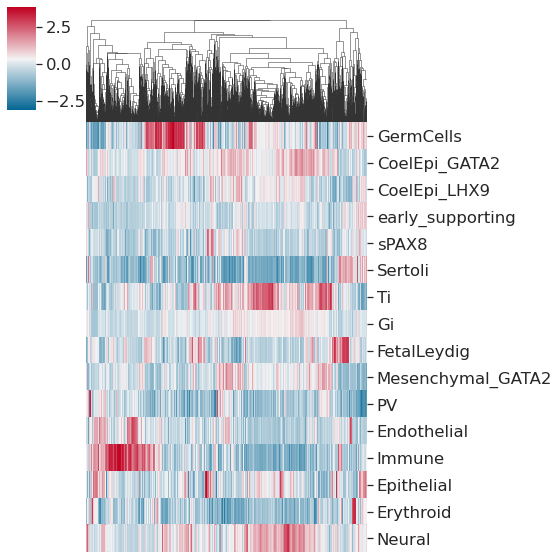

In [23]:
heatmap_TFs = sns.clustermap(chromvar_assay_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = my_cmap)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_july2021/figures_males/heatmap_males_TFs.pdf")


### Select top 3 TFs per cell type 

In [31]:
top_tfs = []
for c in chromvar_assay_zscore.index:
    df_c = chromvar_assay_zscore.loc[c]
    df_c = df_c.sort_values(axis = 0, ascending = False)
    top_4 = df_c[0:7].index
    top_tfs.extend(top_4)

In [32]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore[top_tfs]

In [33]:
chromvar_assay_zscore_top4.columns[90:100]

Index(['PEBB-HUMAN.H10MO.C', 'HNF1B-HUMAN.H10MO.B', 'HNF1B.MA0153.2',
       'HNF1A.MA0046.2', 'HNF1B.SwissRegulon', 'HNF1A-HUMAN.H10MO.A',
       'HNF1A.SwissRegulon', 'GRHL2.MA1105.1', 'GATA1::TAL1.MA0140.2',
       'GATA1-HUMAN.H10MO.A'],
      dtype='object')

In [34]:
to_plot = ['NFYB.MA0502.1','NFYA.MA0060.3','CEBPZ.SwissRegulon',
        'SOX7.SwissRegulon','ZNF675.HOMER',  'FOXA2-HUMAN.H10MO.A',
           'PROX1-HUMAN.H10MO.D',  'TEAD4-HUMAN.H10MO.A',   'EGR2.SwissRegulon',
           'OVOL1.SwissRegulon','TBX15.SwissRegulon',  'MESP1.SwissRegulon',
       'PAX1.SwissRegulon', 'PAX9.MA0781.1', 'THAP1.MA0597.1', 
           'DMRT3.MA0610.1','DMRT6.HOMER',  'SOX10-HUMAN.H10MO.D', 
           'VSX1.MA0725.1','VSX2.MA0726.1',
       'POU6F2.MA0793.1',
       'HOXA9.SwissRegulon',  'HXC6-HUMAN.H10MO.D', 'ZNF317.HOMER',
           'RORA-HUMAN.H10MO.B', 'RORG-HUMAN.H10MO.C', 'RORC.SwissRegulon',
           'HSF2-HUMAN.H10MO.A', 'STAT5A.SwissRegulon',  'HSF1-HUMAN.H10MO.A',
           'EBF1.MA0154.3','EBF3.SwissRegulon', 'MEF2D-HUMAN.H10MO.C',
      'FLI1.SwissRegulon','FEV-HUMAN.H10MO.C', 'EHF-HUMAN.H10MO.S',
           'SPI1.MA0080.4','SPIC.SwissRegulon', 'SPIB-HUMAN.H10MO.B', 
           'HNF1B.MA0153.2', 'HNF1A.MA0046.2', 'GRHL2.MA1105.1',
    'GATA1-HUMAN.H10MO.A', 'GATA2-HUMAN.H10MO.A',  'GATA6.SwissRegulon',
           'PRRX1.SwissRegulon', 'PHX2A-HUMAN.H10MO.D',
       'PHX2B-HUMAN.H10MO.D',
       
           ]
len(to_plot)

48

In [35]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore_top4[to_plot]
chromvar_assay_zscore_top4.columns

Index(['NFYB.MA0502.1', 'NFYA.MA0060.3', 'CEBPZ.SwissRegulon',
       'SOX7.SwissRegulon', 'ZNF675.HOMER', 'FOXA2-HUMAN.H10MO.A',
       'PROX1-HUMAN.H10MO.D', 'TEAD4-HUMAN.H10MO.A', 'EGR2.SwissRegulon',
       'OVOL1.SwissRegulon', 'TBX15.SwissRegulon', 'MESP1.SwissRegulon',
       'PAX1.SwissRegulon', 'PAX9.MA0781.1', 'THAP1.MA0597.1',
       'DMRT3.MA0610.1', 'DMRT3.MA0610.1', 'DMRT6.HOMER', 'DMRT6.HOMER',
       'SOX10-HUMAN.H10MO.D', 'VSX1.MA0725.1', 'VSX2.MA0726.1',
       'POU6F2.MA0793.1', 'HOXA9.SwissRegulon', 'HXC6-HUMAN.H10MO.D',
       'ZNF317.HOMER', 'RORA-HUMAN.H10MO.B', 'RORG-HUMAN.H10MO.C',
       'RORC.SwissRegulon', 'HSF2-HUMAN.H10MO.A', 'STAT5A.SwissRegulon',
       'HSF1-HUMAN.H10MO.A', 'EBF1.MA0154.3', 'EBF3.SwissRegulon',
       'MEF2D-HUMAN.H10MO.C', 'FLI1.SwissRegulon', 'FEV-HUMAN.H10MO.C',
       'EHF-HUMAN.H10MO.S', 'SPI1.MA0080.4', 'SPIC.SwissRegulon',
       'SPIB-HUMAN.H10MO.B', 'HNF1B.MA0153.2', 'HNF1A.MA0046.2',
       'GRHL2.MA1105.1', 'GATA1-HUMAN.H10MO

In [36]:
chromvar_assay_zscore_top4.columns = [col.split(".")[0] for col in chromvar_assay_zscore_top4.columns]

In [37]:
chromvar_assay_zscore_top4.columns = [col.split("-")[0] for col in chromvar_assay_zscore_top4.columns]

In [38]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore_top4.loc[:,~chromvar_assay_zscore_top4.columns.duplicated()]
chromvar_assay_zscore_top4.shape

(16, 48)

In [39]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


<ipython-input-39-63a9665b3b7d>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


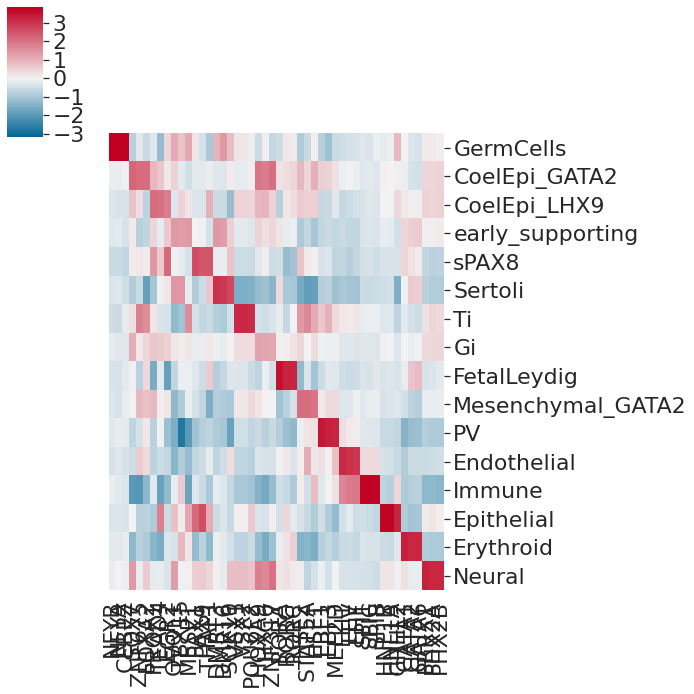

In [46]:
sns.set(font_scale=2)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_top4, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(10, 10),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_july2021/figures_males/heatmap_males_TFs_top3_curated_fake.pdf")


### Plot TFs associated with DSD

In [109]:
dsd_tfs = ['ARX', 'ATRX', 'BMP15', 'CBX2', 'DAX1', 'DHH', 'DHX37', 'DMRT1', 'EMX2', 'ESR2', 'FGF9', 'FGFR2', 'FOXL2',
          'GATA4', 'HHAT', 'MAP3K1', 'NR2F2', 'NR5A1', 'NUP107', 'RSPO1', 'SOX3', 'SOX8', 'SOX9', 'SOX10', 'SRY', 
          'STARD8', 'TSPYL1', 'WNT4', 'WT1', 'WWOX', 'ZFPM2', 'ZNRF3']

In [116]:
dsd_tfs = ['GATA4', 'LHX9', 'ARX', 'GATA2', 'NR2F1']

In [117]:
df = pd.DataFrame(chromvar_assay_zscore.columns)

In [118]:
df[0][df[0].str.contains('|'.join(dsd_tfs))]


164           LHX9.MA0701.1
190          NR2F1.MA0017.2
343          BARX1.MA0875.1
376          GATA2.MA0036.3
467       ARX-HUMAN.H10MO.D
478     BARX1-HUMAN.H10MO.D
479     BARX2-HUMAN.H10MO.D
625     GATA2-HUMAN.H10MO.A
627     GATA4-HUMAN.H10MO.B
754      LHX9-HUMAN.H10MO.D
1102       ARX.SwissRegulon
1116     BARX1.SwissRegulon
1117     BARX2.SwissRegulon
1263     GATA2.SwissRegulon
1265     GATA4.SwissRegulon
1407      LHX9.SwissRegulon
1501     NR2F1.SwissRegulon
Name: 0, dtype: object

In [112]:
dsd_tfs_present = ['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon', 'ESR2.SwissRegulon',
                  'GATA4.SwissRegulon', 'FOXL2.HOMER',
                  'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 
                   'SOX8-HUMAN.H10MO.D', 'SOX9.SwissRegulon', 
                  'SOX10.SwissRegulon', 'SRY.SwissRegulon', 
                  'WT1-HUMAN.H10MO.D']


In [119]:
dsd_tfs_present = ['GATA4-HUMAN.H10MO.B', 'GATA4.SwissRegulon', 'LHX9.MA0701.1', 'LHX9.SwissRegulon', 
                  'ARX-HUMAN.H10MO.D', 'ARX.SwissRegulon', 'GATA2.SwissRegulon', 'GATA2.MA0036.3', 
                  'NR2F1.SwissRegulon', 'NR2F1.MA0017.2']

In [120]:
chromvar_assay_zscore_DSD = chromvar_assay_zscore[dsd_tfs_present]
chromvar_assay_zscore_DSD.columns

Index(['GATA4-HUMAN.H10MO.B', 'GATA4.SwissRegulon', 'LHX9.MA0701.1',
       'LHX9.SwissRegulon', 'ARX-HUMAN.H10MO.D', 'ARX.SwissRegulon',
       'GATA2.SwissRegulon', 'GATA2.MA0036.3', 'NR2F1.SwissRegulon',
       'NR2F1.MA0017.2'],
      dtype='object')

In [121]:
chromvar_assay_zscore_DSD.columns = [col.split(".")[0] for col in chromvar_assay_zscore_DSD.columns]
chromvar_assay_zscore_DSD.columns = [col.split("-")[0] for col in chromvar_assay_zscore_DSD.columns]


In [124]:
chromvar_assay_zscore_DSD = chromvar_assay_zscore_DSD.loc[['CoelEpi_GATA2', 'CoelEpi_LHX9', 'Ti', 'Gi', 
                                                          'FetalLeydig', 'Mesenchymal_GATA2']]

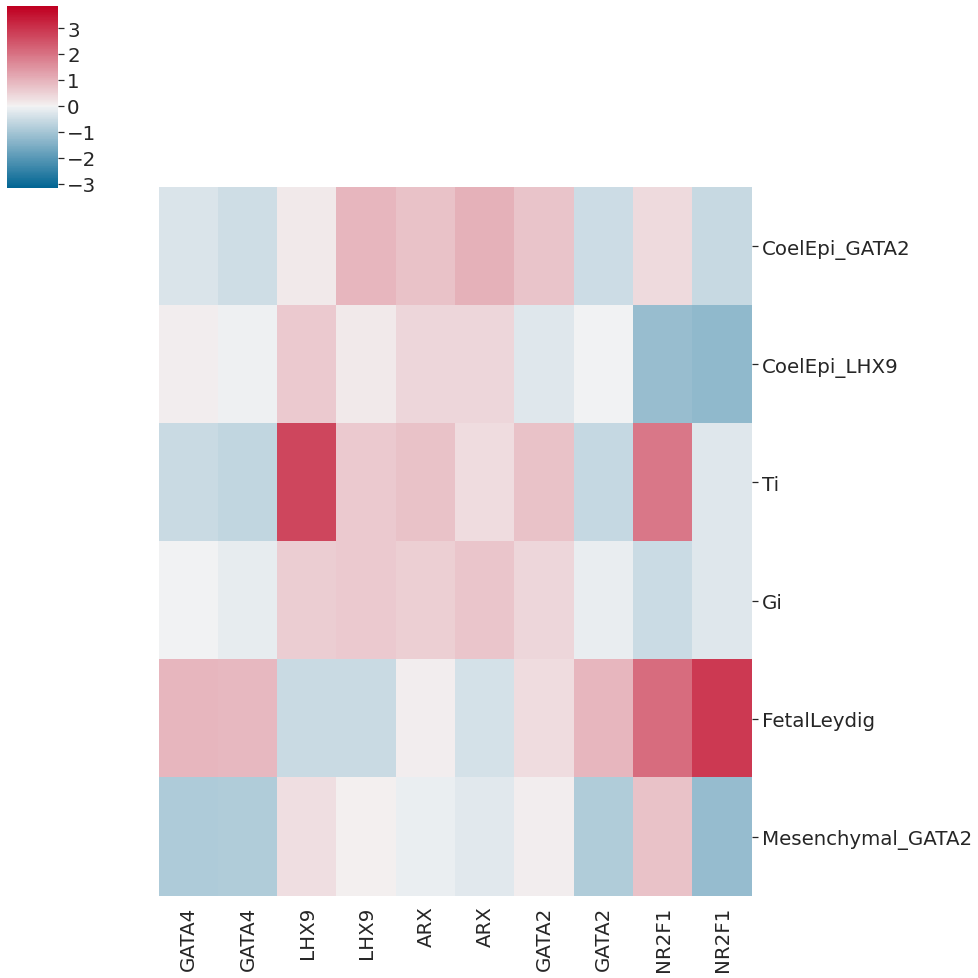

In [125]:
sns.set(font_scale=1.8)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_DSD, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(14, 14),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_july2021/figures_males/DSD_TFs_heatmap.pdf")


#### End of notebook